# Model II 
### The multilevel model for CAR using a Common Markov Gaussian Random Field
 $$ [P , S ] = [P | GMRF] [ S | GMRF] $$

In [27]:
## Run the script
#setwd('/app/external_plugins/biospytial_rwrapper/CAR-1SDM/R/')
setwd('/main/app/external_plugins/biospytial_rwrapper/CAR-1SDM/')
source('R/preprocess_data.R')
source("model2_multilevel/run-joint-multilevel.R")
## Make ROC curve
library(pROC)
library('caret')
#trains = createFolds(y = DataFrame$species, k=7, returnTrain = TRUE)


In [153]:

trials = rep(1,2 *nK)
burnin = 90000
n.sample = 100000
thin = 5
## Toy example
#burnin = 50
#n.sample = 100
#thin = 1

l <- list()
i = 1
nS = dim(Py)[1]

nonas = which(! is.na(DataFrame$species) )
Y_withoutNA = DataFrame$species[nonas]
validate = createFolds(y = Y_withoutNA, k=7, returnTrain = FALSE)

validate.index.presences = lapply(validate, function(x){x + nS})

## customised for the multilevel preprocessing (i.e. DD instead of the trad. variable that I called `DataFrame` )
DD$presences <- DD$response
DD$predicted_values_CV <- NA


## Configure correlation for each cell.
## In this case, the correlation (similar to nugget effect) will be the same for all cells in P and for all cells in S.
## It can also be changed to assign correlations for same cell (i.e. the correlation between the cell i,j in S is the same as in P)
ind.re = c(rep(1,nK),rep(2,nK))




In [154]:
#formula_sample =  sample ~ Disttoroadm + Populationm
#formula_presence = species ~ Elevationm + Precipitationm
formula <- response ~ Disttoroadm + Populationm + Elevationm + Precipitationm
#form2 = response ~ Precipitationm:Elevationm
for (fold in validate.index.presences) {
    
    ## Substitue by NA (to be predicted..)
    DD$response[fold] <- NA
    
    model2 <- S.CARmultilevel(formula,family = 'binomial',
                             trials=trials,
                             W=M_bis,
                             ind.area=idarea,
                             #ind.re=factor(idarea),
                             ind.re = factor(ind.re),
                             rho=1,
                             burnin=burnin,
                             n.sample=n.sample,
                             data=DD)
    
    ## return DataFrame$species to original 
    ## Beware of DD...
    DD$response <- DD$presences
    ## Return original values
    ## Aquí hay que ver si los fitted values corresponden al indice 
    predicted.probability = model2$fitted.values[fold]
    DD$predicted_values_CV[fold] <- predicted.probability

    pROC_obj <- roc(DD$response[fold],predicted.probability)

    l[[i]] <- pROC_obj
    i = i + 1
}

Setting up the model.
Generating 10000 post burnin and thinned (if requested) samples.
  |======================================                                |  55%

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Warning message in plot.ci.se(sens.ci, type = "shape", col = "lightblue"):
“Low definition shape.”


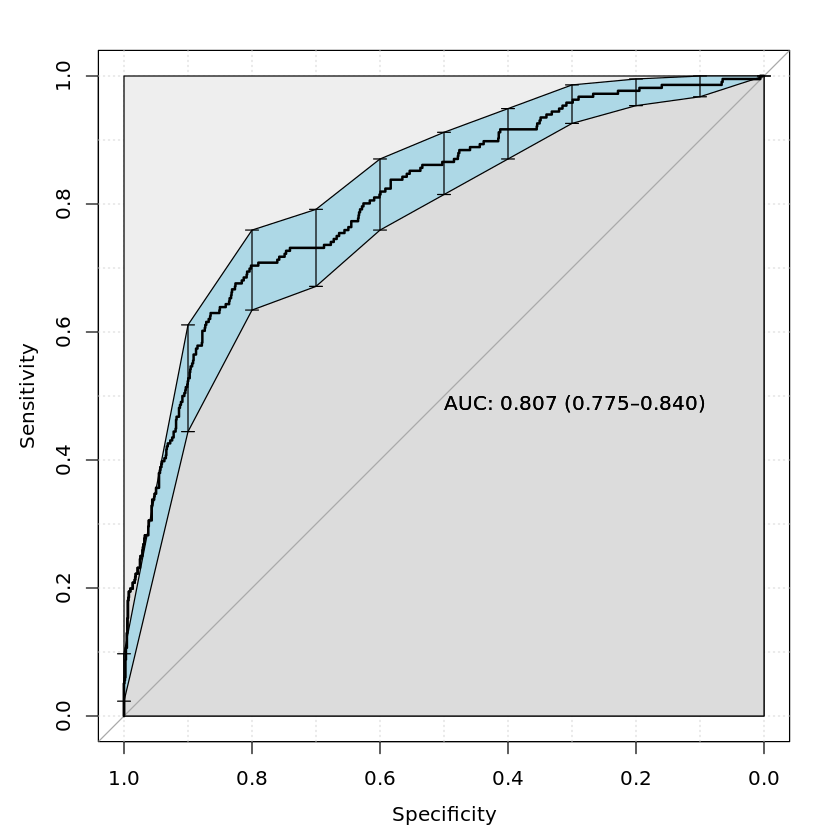

In [91]:
#100k samps
#pROC_obj <- roc(DD$response[presences.index],DD$predicted_values_CV[presences.index],
pROC_obj <- roc(DD$response[presences.index],joint_SP,                
               smoothed= TRUE,
               ci = TRUE, ci.alpha=0.9, stratified=FALSE,
               plot=TRUE, auc.polygon=TRUE, max.auc.polygon=TRUE, grid=TRUE,
               print.auc=TRUE, show.thres=TRUE)
sens.ci <- ci.se(pROC_obj)
plot(sens.ci,type="shape",col="lightblue")
plot(sens.ci, type="bars")